#### SQAE with DRC 

Trying the Quantum autoencoder on larger MNIST images by encoding the high dimensional data using DRC

### imports 

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from hep_VQAE import data_preprocessing as dp
import tensorflow as tf
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
import time
import h5py
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

2022-08-25 00:01:38.120898: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-25 00:01:38.120920: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### data 

In [2]:
test = h5py.File("small_quark_gluon_12","r")

x_s = test.get('X')
y_s = test.get('y')

In [3]:
x_train, x_val, y_train, y_val = train_test_split(x_s[:],
                                                  y_s[:],
                                                  test_size=0.2, shuffle=True)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train,
                                                    test_size=0.4, shuffle=True)

In [4]:
x_train_1 = x_train[y_train==1]
x_train = x_train[y_train==0]

x_val_1 = x_val[y_val==1]
x_val = x_val[y_val==0]

x_test_1 = x_test[y_test==1]
x_test = x_test[y_test==0]

In [5]:
div = np.max(x_train_1,axis=(1,2)).reshape(x_train_1.shape[0],1,1)
div[div == 0] = 1
x_train_1 = x_train_1 / div
div = np.max(x_train,axis=(1,2)).reshape(x_train.shape[0],1,1)
div[div == 0] = 1
x_train = x_train / div

div = np.max(x_val_1,axis=(1,2)).reshape(x_val_1.shape[0],1,1)
div[div == 0] = 1
x_val_1 = x_val_1 / div
div = np.max(x_val,axis=(1,2)).reshape(x_val.shape[0],1,1)
div[div == 0] = 1
x_val = x_val / div

div = np.max(x_test_1,axis=(1,2)).reshape(x_test_1.shape[0],1,1)
div[div == 0] = 1
x_test_1 = x_test_1 / div
div = np.max(x_test,axis=(1,2)).reshape(x_test.shape[0],1,1)
div[div == 0] = 1
x_test = x_test / div

# Circuit

In [6]:
DATA_QBITS = 9
LATENT_QBITS = 3
TRASH_QBITS = DATA_QBITS - LATENT_QBITS
TOTAL_QBITS = DATA_QBITS + TRASH_QBITS + 1

INPUT_DATA_SIZE = 12

DRCs = 3

In [7]:
dev1 = qml.device('lightning.qubit', wires=TOTAL_QBITS)

In [8]:
def single_upload(params, data, wire):
    for i, d in enumerate(data.flatten()):
        if i % 3 == 0:
            qml.RX(params[i * 2] + params[i * 2 + 1] * d, wires=wire)
        if i % 3 == 1:
            qml.RY(params[i * 2] + params[i * 2 + 1] * d, wires=wire)
        if i % 3 == 2:
            qml.RZ(params[i * 2] + params[i * 2 + 1] * d, wires=wire)

def conv_upload(params, img, kernel_size, stride, wires):
    number_of_kernel_uploads = len(list(range(0,img.shape[1]-kernel_size+1,stride)))*len(list(range(0,img.shape[0]-kernel_size+1,stride)))
    params_per_upload = len(params) // number_of_kernel_uploads
    upload_counter = 0
    wire = 0
    for y in range(0,img.shape[1]-kernel_size+1,stride):
        for x in range(0,img.shape[0]-kernel_size+1,stride):
            single_upload(params[upload_counter * params_per_upload: (upload_counter + 1) * params_per_upload],
                          img[y:y+kernel_size, x:x+kernel_size], wires[wire])
            upload_counter = upload_counter + 1
            wire = wire + 1
            
def circular_entanglement(wires):
    qml.CNOT(wires=[wires[-1], 0] )
    for i in range(len(wires)-1):
        qml.CNOT(wires=[i, i+1])

@qml.qnode(dev1, diff_method="adjoint")
def circuit(params, data):

    kernel_size = 4
    stride = 4
    
    number_of_kernel_uploads = len(list(range(0,data.shape[1]-kernel_size+1,stride)))**2
    num_upload_params = number_of_kernel_uploads*2*kernel_size**2
    
    for i in range(DRCs):
        conv_upload(params[i*num_upload_params:(i+1)*num_upload_params], data, kernel_size, stride, list(range(number_of_kernel_uploads)))
        circular_entanglement(list(range(number_of_kernel_uploads)))

    qml.Hadamard(wires=TOTAL_QBITS-1)
    for i in range(TRASH_QBITS):
        #c += cirq.ControlledGate(sub_gate=cirq.SWAP, num_controls=1).on(swap_qbit, reference_qbits[i], network_qbits[num_data_qbits - num_latent_qbits:][i])
        qml.CSWAP(wires=[TOTAL_QBITS - 1, LATENT_QBITS + i, DATA_QBITS + i])
    qml.Hadamard(wires=TOTAL_QBITS-1)
    return qml.expval(qml.PauliZ(TOTAL_QBITS-1))

In [9]:
data = np.random.rand(INPUT_DATA_SIZE,INPUT_DATA_SIZE)

kernel_size = 4
stride = 4
number_of_kernel_uploads = len(list(range(0,data.shape[0]-kernel_size+1,stride)))**2
num_upload_params = number_of_kernel_uploads*2*kernel_size**2

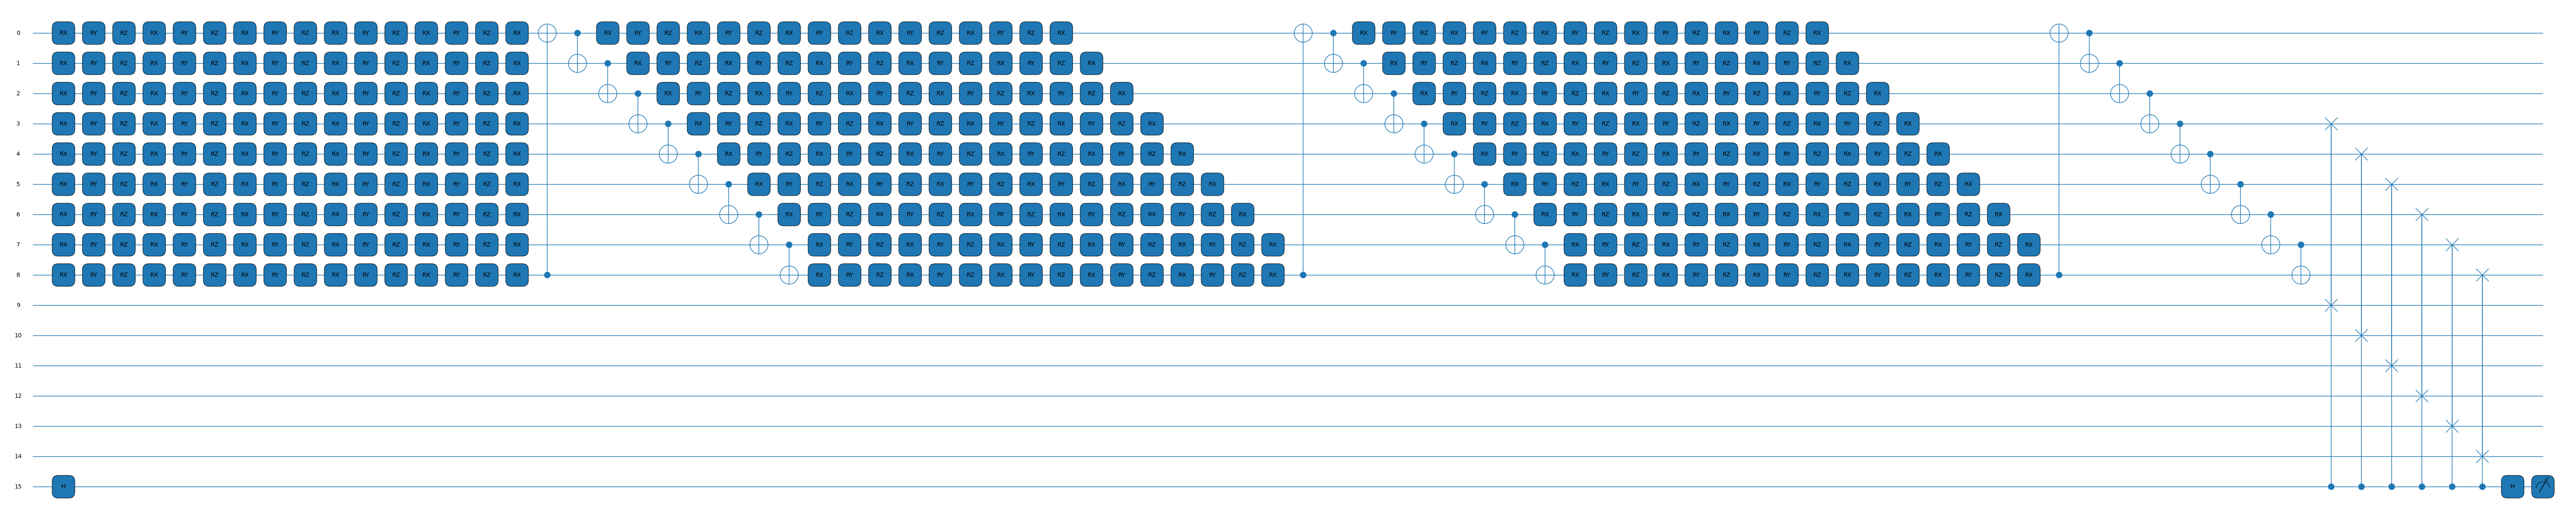

In [10]:
fig, ax = qml.draw_mpl(circuit)(np.ones(DRCs*num_upload_params),data)
fig.show()

In [11]:
def cost_batch(params, batch):
    loss = 0.0
    for i in batch:
        f = circuit(params, i)
        loss = loss + (1 - f) ** 2
    return loss / len(batch)

def cost(params):
    loss = 0.0
    for i in range(len(x_train)):
        f = circuit(params, x_train[i])
        #loss = loss + np.log10(1 - f) #** 2
        loss = loss + (1 - f) ** 2
    return loss / len(x_train)

def cost_sample(params, single_sample):
    return (1 - circuit(params, single_sample)) ** 2

In [12]:
def iterate_minibatches(data, batch_size):
    for start_idx in range(0, data.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield data[idxs]

In [13]:
learning_rate = 0.01
epochs = 10
batch_size = 30

In [14]:
opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
#opt = qml.QNGOptimizer(learning_rate)
# opt = GradientDescentOptimizer(learning_rate)

In [15]:
weight_shapes = {"weights": (DRCs*num_upload_params)}
params = np.random.uniform(size=weight_shapes["weights"], requires_grad=True)

In [16]:
x_train_small = x_train[:3000]
x_train_1_small = x_train_1[:3000]
x_test_small = x_test[:900]
x_test_1_small = x_test_1[:900]

In [17]:
start = time.time()

for it in range(epochs):
    #start_b = time.time()
    for j,Xbatch in enumerate(iterate_minibatches(x_train_1_small, batch_size=batch_size)):  
    #for j, sample in enumerate(x_train_small):        
        #sample = np.array(sample, requires_grad=False)
        #cost_fn = lambda p: cost_sample(p, sample)
        cost_fn = lambda p: cost_batch(p, Xbatch)
        #metric_fn = lambda p: qml.metric_tensor(circuit, approx="block-diag")(p, sample)
        params = opt.step(cost_fn, params)#, metric_tensor_fn=metric_fn) 
        print(j, end="\r")
        #if j % 20 == 0:
        #    end_b = time.time()
        #    loss = cost_batch(params,Xbatch)
        #    print(f"Step: {j} | Loss: {loss:.3} | avg step time {(end_b - start_b) / 10 :.3}")
        #    start_b = time.time()

    loss = cost_batch(params,x_train_1_small[:100])
    val_loss = cost_batch(params, x_test_1_small[:100])
    print("____")
    print(f"Epoch: {it} | Loss: {loss:.3} | Val Loss {val_loss:.3}")
    print("____")

val_loss_final = cost_batch(params, x_test_1_small[:600]
print("final val loss", val_loss_final)
    
end = time.time()

print(f"Time for {epochs} epochs: {end - start}")

____
Epoch: 0 | Loss: 0.00337 | Val Loss 0.00316
____
____
Epoch: 1 | Loss: 0.00088 | Val Loss 0.000902
____
____
Epoch: 2 | Loss: 0.000358 | Val Loss 0.00039
____
____
Epoch: 3 | Loss: 0.000182 | Val Loss 0.000207
____
____
Epoch: 4 | Loss: 0.000105 | Val Loss 0.000124
____
____
Epoch: 5 | Loss: 6.55e-05 | Val Loss 7.9e-05
____
____
Epoch: 6 | Loss: 4.33e-05 | Val Loss 5.32e-05
____
____
Epoch: 7 | Loss: 3e-05 | Val Loss 3.75e-05
____
____
Epoch: 8 | Loss: 2.16e-05 | Val Loss 2.73e-05
____


IOStream.flush timed out


____
Epoch: 9 | Loss: 1.6e-05 | Val Loss 2.05e-05
____
Time for 10 epochs: 37107.188712120056


In [18]:
pred_zero = np.array([circuit(params,i) for i in x_test_small])
print("Median zero reconstruciton fidelities: ",np.median(pred_zero))

pred_one = np.array([circuit(params,i) for i in x_test_1_small])
print("Median one reconstruciton fidelities: ",np.median(pred_one))

Median zero reconstruciton fidelities:  0.9983404774838258
Median one reconstruciton fidelities:  0.9984911545381188


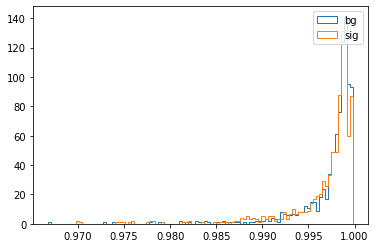

In [21]:
bins = np.histogram(np.hstack((pred_zero.reshape((pred_zero.shape[0],)), pred_one.reshape((pred_one.shape[0],)))), bins=100)[1]
plt.hist(pred_one, histtype='step', label="bg",bins=bins)
plt.hist(pred_zero, histtype='step', label="sig",bins=bins)
plt.legend()

AUC:  0.5351179012345679


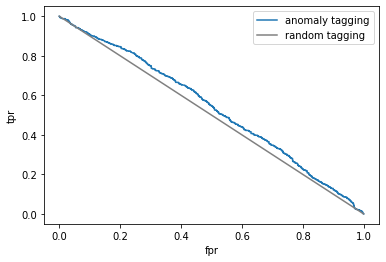

In [22]:
from sklearn.metrics import roc_auc_score, roc_curve

#bce_background = 1-pred_six
#bce_signal = 1-pred_three
bce_background = 1-pred_one
bce_signal = 1-pred_zero

y_true = np.append(np.zeros(len(bce_background)), np.ones(len(bce_signal)))
y_pred = np.append(bce_background, bce_signal)
auc = roc_auc_score(y_true, y_pred)

print("AUC: ", auc)

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
tnr = 1 - fpr
x = np.linspace(0,1,50)
y_rnd = 1 - x
plt.plot(tnr,tpr, label="anomaly tagging")
plt.plot(x,y_rnd, label="random tagging", color='grey')
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()